In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from __future__ import division, print_function

# Let's generate some data from a state space model

In [2]:
np.random.seed(12345)  # set random seed

We'll generate data according to a simple state space model and then recover the underlying model via the Kalman filter/smoother. We follow the conventions of [Durbin and Koopman (2012)](http://www.ssfpack.com/DKbook.html).

### Observation model

$$\begin{align}
y_t &= Z_t \alpha_t + \varepsilon_t \\
\varepsilon_t &\sim \mathcal{N}(0, H_t)
\end{align}$$

In [3]:
Z = np.array([[1, -1], [0, 1], [1, 0]])  # observation matrix
H = 0.1 * np.array([[1, 0, 0], [0, 1, 0.2], [0, 0.2, 1]])

Np, Nm = Z.shape

In [4]:
assert(H.shape == (Np, Np))

### State evolution model

$$\begin{align}
\alpha_{t+1} &= T_t \alpha_t + R_t \eta_t \\
\eta_t &\sim \mathcal{N}(0, Q_t)
\end{align}$$

In [5]:
th = 10 * np.pi / 180  # rotation angle
T = np.array([[np.cos(th), np.sin(th)], [-np.sin(th), np.cos(th)]])  # rotation matrix
R = np.array([1.1, 1])[:, np.newaxis]
Q = np.array([0.05])[:, np.newaxis]

_, Nr = R.shape

In [6]:
assert(T.shape == (Nm, Nm))
assert(R.shape[0] == Nm)
assert(Q.shape == (Nr, Nr))

### Prior

$$
\alpha_1 \sim \mathcal{N}(a_1, P_1)
$$

In [7]:
a_init = np.zeros(Nm)
P_init = np.eye(Nm)

In [8]:
assert(P_init.shape == (Nm, Nm))

## Now generate some data

In [9]:
Ny = 100  # number of samples

Preallocate data arrays:

In [10]:
alpha = np.empty((Ny, Nm))
y = np.empty((Ny, Np))
eps = np.empty((Ny, Np))
eta = np.empty((Ny, Nr))

Initialize:

In [11]:
alpha[0] = np.random.multivariate_normal(a_init, P_init)

In [12]:
for t in xrange(Ny):
    eps[t] = np.random.multivariate_normal(np.zeros(Np), H)
    eta[t] = np.random.multivariate_normal(np.zeros(Nr), Q)
    y[t] = Z.dot(alpha[t]) + eps[t]
    if t + 1 < Ny:
        alpha[t + 1] = T.dot(alpha[t]) + R.dot(eta[t])

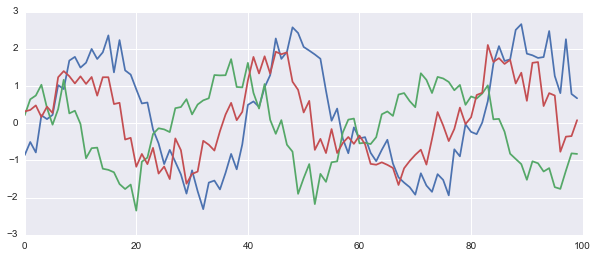

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(y);

# Kalman filter (forward)

Preallocate some arrays for the filter.

In [14]:
a = np.empty((Ny, Nm))
P = np.empty((Ny, Nm, Nm))
aa = np.empty((Ny, Nm))
PP = np.empty((Ny, Nm, Nm))
v = np.empty((Ny, Np))
F = np.empty((Ny, Np, Np))
K = np.empty((Ny, Nm, Np))

Set some priors:

In [15]:
a[0] = a_init
P[0] = P_init

Now filter! In DK conventions, this is
$$\begin{align}
v_t &= y_t - Z_t a_t  \\
F_t &= Z_t P_t Z_t^\top + H_t  \\
aa \equiv \mathbb{E}(\alpha_t\vert y_{1:t}) &= a_t + P_t Z_t^\top F_t^{-1} v_t  \\
PP \equiv \mathrm{var}(\alpha_t \vert y_{1:t}) &= P_t - P_t Z_t^\top F_t^{-1} Z_t P_t  \\
K_t &= T_t P_t Z_t^\top F_t^{-1}  \\
a_{t + 1} &= T_t a_t + K_t v_t  \\
P_{t + 1} &= T_t P_t(T_t - K_t Z_t)^\top + R_t Q_t R_t^\top
\end{align}$$

In [16]:
for t in xrange(Ny):
    v[t] = y[t] - Z.dot(a[t])
    F[t] = Z.dot(P[t]).dot(Z.T) + H
    Finv = np.linalg.inv(F[t])
    aa[t] = a[t] + P[t].dot(Z.T).dot(Finv).dot(v[t])
    PP[t] = P[t] - P[t].dot(Z.T).dot(Finv).dot(Z).dot(P[t])
    K[t] = T.dot(P[t]).dot(Z.T).dot(Finv)
    if t + 1 < Ny:
        a[t + 1] = T.dot(a[t]) + K[t].dot(v[t])
        P[t + 1] = T.dot(P[t]).dot((T - K[t].dot(Z)).T) + R.dot(Q).dot(R.T)

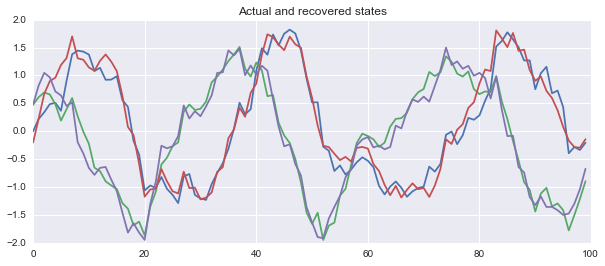

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(aa)
plt.plot(alpha)
plt.title('Actual and recovered states')
pass